In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import time
%matplotlib inline  
import sys
sys.path.append('/gpfs2/projects/project-bus_capstone_2016/workspace/mu529/Bus-Capstone')

# these two modules are homemade
import gtfs
import arrivals
import ttools
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')

In [2]:
# get all the schedule data. (subset can be created later)
trips = gtfs.load_trips('2015-12-03','gtfs/')
#stops = gtfs.load_stops('2015-12-03','gtfs/')
stop_times, tz_sched = gtfs.load_stop_times('2015-12-03','gtfs/')
tcal=gtfs.TransitCalendar('2015-12-03')
active_services = tcal.get_service_ids('2015-12-03')
active_trips = trips.service_id.isin(active_services)
active_stops = stop_times.reset_index().set_index('trip_id').loc[active_trips]
print 'Finished loading GTFS data.'

Finished loading GTFS data.


In [3]:
#
# active_stops = stop_times.reset_index().set_index('trip_id')

In [4]:
active_stops['sched_hour'] = active_stops.arrival_time.str[:2].astype(int)
active_stops['sched_arrival_time'] = active_stops.arrival_time.apply(ttools.parseTime)

In [5]:
sched_times = active_stops.join(trips['route_id'],how='left')

In [6]:
sched_times = sched_times.reset_index().sort(['route_id','sched_arrival_time'])

sec = ttools.datetime.timedelta(seconds=1)
def sched_headways(df):
    return df.sort('sched_arrival_time')['sched_arrival_time'].diff()/sec

In [7]:
sec = ttools.datetime.timedelta(seconds=1)
sched_times['sched_headway'] = sched_times.groupby(['route_id','stop_id'])['sched_arrival_time'].diff()/sec

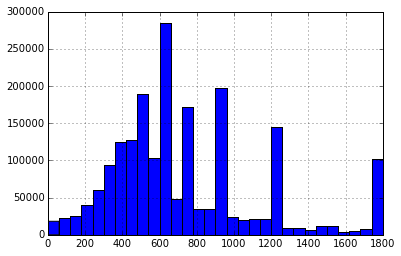

In [12]:
sched_times['sched_headway'].hist(range=(0,1800),bins=30)

In [13]:
sched_times.set_index(['trip_id','stop_id'],inplace=True,verify_integrity=True)

### FML

In [14]:
interpolated = pd.read_csv('dec2015_interpolated.csv')

In [18]:
interpolated = interpolated[interpolated['trip_date']<='2015-12-04']

In [19]:
# interpolated['hour'] = interpolated.interpolated_arrival_time.str[:2]
interpolated['interpolated_arrival_time'] = pd.to_timedelta(interpolated['interpolated_arrival_time'])

In [20]:
interpolated.head()

,ROUTE_ID,TRIP_ID,trip_date,vehicle_id,STOP_ID,interpolated_arrival_time
76,BX4,GH_D5-Weekday-SDon-072200_BX44A_115,2015-12-01,1232,100204,12:17:12.252435
77,BX4,GH_D5-Weekday-SDon-072200_BX44A_115,2015-12-01,1232,100206,12:18:47.609879
78,BX4,GH_D5-Weekday-SDon-072200_BX44A_115,2015-12-01,1232,100207,12:20:41.306924
79,BX4,GH_D5-Weekday-SDon-072200_BX44A_115,2015-12-01,1232,100209,12:23:33.335432
80,BX4,GH_D5-Weekday-SDon-072200_BX44A_115,2015-12-01,1232,100211,12:25:13.534420


In [21]:
merged = interpolated.merge(sched_times[['sched_arrival_time','sched_hour','sched_headway']],how='left',left_on=['TRIP_ID','STOP_ID'],right_index=True)

In [22]:
merged.head()

,ROUTE_ID,TRIP_ID,trip_date,vehicle_id,STOP_ID,interpolated_arrival_time,sched_arrival_time,sched_hour,sched_headway
76,BX4,GH_D5-Weekday-SDon-072200_BX44A_115,2015-12-01,1232,100204,12:17:12.252435,12:03:27,12,1200
77,BX4,GH_D5-Weekday-SDon-072200_BX44A_115,2015-12-01,1232,100206,12:18:47.609879,12:04:58,12,1200
78,BX4,GH_D5-Weekday-SDon-072200_BX44A_115,2015-12-01,1232,100207,12:20:41.306924,12:06:26,12,1200
79,BX4,GH_D5-Weekday-SDon-072200_BX44A_115,2015-12-01,1232,100209,12:23:33.335432,12:08:00,12,1200
80,BX4,GH_D5-Weekday-SDon-072200_BX44A_115,2015-12-01,1232,100211,12:25:13.534420,12:10:13,12,1217


In [23]:
# bools = interpolated.duplicated(subset=['route','trip_id','trip_date','vehicle_id','stop_id'],take_last=False) + interpolated.duplicated(subset=['route','trip_id','trip_date','vehicle_id','stop_id'],take_last=True)
# interpolated[bools].sort(['route','trip_id','trip_date','vehicle_id']).shape

In [24]:
merged.set_index(['ROUTE_ID','trip_date','STOP_ID'],inplace=True)

In [25]:
merged.head()

TRIP_ID  vehicle_id  \
ROUTE_ID trip_date  STOP_ID                                                    
BX4      2015-12-01 100204   GH_D5-Weekday-SDon-072200_BX44A_115        1232   
                    100206   GH_D5-Weekday-SDon-072200_BX44A_115        1232   
                    100207   GH_D5-Weekday-SDon-072200_BX44A_115        1232   
                    100209   GH_D5-Weekday-SDon-072200_BX44A_115        1232   
                    100211   GH_D5-Weekday-SDon-072200_BX44A_115        1232   

                             interpolated_arrival_time  sched_arrival_time  \
ROUTE_ID trip_date  STOP_ID                                                  
BX4      2015-12-01 100204             12:17:12.252435            12:03:27   
                    100206             12:18:47.609879            12:04:58   
                    100207             12:20:41.306924            12:06:26   
                    100209             12:23:33.335432            12:08:00   
                    100211             12:25:13.534420            12:10:13   

                             sched_hour  sched_headway  
ROUTE_ID trip_date  STOP_ID                             
BX4      2015-12-01 100204           12           1200  
                    100206           12           1200  
                    100207           12           1200  
                    100209           12           1200  
                    100211           12           1217

In [26]:
merged = merged.set_index('interpolated_arrival_time',append=True,drop=False).sort_index()

In [27]:
sec = ttools.datetime.timedelta(seconds=1)
merged['inter_headway'] = merged.groupby(level=(0,1,2))['interpolated_arrival_time'].diff()/sec

In [28]:
merged.head(25)

TRIP_ID  \
ROUTE_ID trip_date  STOP_ID interpolated_arrival_time                                    
B1       2015-12-01 300000  05:04:59.663721             UP_D5-Weekday-SDon-030500_B1_5   
                            05:30:42.700777             UP_D5-Weekday-SDon-033000_B1_7   
                            10:09:01.078491            UP_D5-Weekday-SDon-060800_B1_13   
                            12:37:29.048152            UP_D5-Weekday-SDon-075100_B1_17   
                            12:53:32.616912            UP_D5-Weekday-SDon-076300_B1_11   
                            13:36:15                    UP_D5-Weekday-SDon-081100_B1_9   
                            13:49:00.077493            UP_D5-Weekday-SDon-082300_B1_32   
                            14:00:27.062338            UP_D5-Weekday-SDon-083500_B1_34   
                            14:07:47.069384            UP_D5-Weekday-SDon-084200_B1_36   
                            15:10:24.079422            UP_D5-Weekday-SDon-090900_B1_39   
                            22:14:54                   UP_D5-Weekday-SDon-133000_B1_40   
                    300002  01:00:57.302967             UP_D5-Weekday-SDon-006000_B1_1   
                            02:20:44.756889             UP_D5-Weekday-SDon-014000_B1_1   
                            03:03:45.487774             UP_D5-Weekday-SDon-018000_B1_2   
                            03:40:05.728617             UP_D5-Weekday-SDon-022000_B1_1   
                            05:04:24.933491             UP_D5-Weekday-SDon-030500_B1_5   
                            05:30:18.073091             UP_D5-Weekday-SDon-033000_B1_7   
                            05:45:00.495628             UP_D5-Weekday-SDon-034500_B1_3   
                            06:02:11.119749             UP_D5-Weekday-SDon-036000_B1_2   
                            06:27:14.564137             UP_D5-Weekday-SDon-038600_B1_4   
                            06:35:29.907428             UP_D5-Weekday-SDon-039600_B1_9   
                            06:46:03.693952             UP_D5-Weekday-SDon-040600_B1_5   
                            07:06:02.962673            UP_D5-Weekday-SDon-042300_B1_15   
                            07:23:08.922512            UP_D5-Weekday-SDon-043100_B1_16   
                            07:52:57.040049            UP_D5-Weekday-SDon-046800_B1_11   

                                                       vehicle_id  \
ROUTE_ID trip_date  STOP_ID interpolated_arrival_time               
B1       2015-12-01 300000  05:04:59.663721                  4859   
                            05:30:42.700777                  7169   
                            10:09:01.078491                  7159   
                            12:37:29.048152                  4890   
                            12:53:32.616912                  4880   
                            13:36:15                         7144   
                            13:49:00.077493                  7186   
                            14:00:27.062338                  7162   
                            14:07:47.069384                  7183   
                            15:10:24.079422                  5112   
                            22:14:54                         7178   
                    300002  01:00:57.302967                  4871   
                            02:20:44.756889                  4871   
                            03:03:45.487774                  4882   
                            03:40:05.728617                  4871   
                            05:04:24.933491                  4859   
                            05:30:18.073091                  7169   
                            05:45:00.495628                  5095   
                            06:02:11.119749                  4882   
                            06:27:14.564137                  7185   
                            06:35:29.907428                  5083   
                            06:46:03.693952                  

## Function that can applied repeatedly

In [29]:
def peak_hour_int(x):
    if x >= 7 and x < 9:
        return True
    elif x >= 16 and x < 19:
        return True
    else:
        return False

In [30]:
merged['P_hour'] = map(lambda x:peak_hour_int(x),merged['sched_hour'])

In [31]:
def wait_ass(x,y):
    if x == True:
        if y >= 3*60:
            return False
        else:
            return True
    if x == False:
        if y>= 5*60:
            return False
        else:
            return True         

In [32]:
merged['hw_diff'] = merged['inter_headway']-merged['sched_headway']

In [33]:
merged['wait_ass'] = map(lambda x,y:wait_ass(x,y), merged['P_hour'],merged['hw_diff'])

## Stop and pickle

In [44]:
# merged.to_pickle('dec2015_merged2.pickle')

In [3]:
# merged = pd.read_pickle('dec2015_merged.pickle')

In [4]:
# merged.iloc[20000:30000]

TRIP_ID  \
ROUTE_ID trip_date  STOP_ID interpolated_arrival_time                                     
B1       2015-12-02 300110  07:32:39.164801              UP_D5-Weekday-SDon-041800_B1_1   
                            07:34:15.623246             UP_D5-Weekday-SDon-044700_B1_26   
                            07:35:23.719507             UP_D5-Weekday-SDon-044300_B1_24   
                            07:35:54.776611             UP_D5-Weekday-SDon-042300_B1_14   
                            07:38:20.266083             UP_D5-Weekday-SDon-043500_B1_19   
                            07:39:25.245461             UP_D5-Weekday-SDon-045200_B1_27   
                            07:42:20.049786              UP_D5-Weekday-SDon-042900_B1_6   
                            07:50:11.421316             UP_D5-Weekday-SDon-043600_B1_17   
                            07:54:45.860534              UP_D5-Weekday-SDon-044300_B1_4   
                            08:00:40.582391              UP_D5-Weekday-SDon-045000_B1_9   
                            08:06:42.621118             UP_D5-Weekday-SDon-045700_B1_25   
                            08:12:43.483111              UP_D5-Weekday-SDon-046400_B1_5   
                            08:14:20.809687             UP_D5-Weekday-SDon-049300_B1_20   
                            08:24:49.034488              UP_D5-Weekday-SDon-049900_B1_2   
                            08:24:50.398342             UP_D5-Weekday-SDon-050100_B1_22   
                            08:28:09.686652              UP_D5-Weekday-SDon-050500_B1_1   
                            08:33:09.955536             UP_D5-Weekday-SDon-047000_B1_21   
                            08:37:26.250591             UP_D5-Weekday-SDon-047700_B1_13   
                            08:37:28.029908            FB_D5-Weekday-SDon-051000_B49_15   
                            08:38:02.459830             UP_D5-Weekday-SDon-050600_B1_14   
                            08:38:26.754332            FB_D5-Weekday-SDon-051200_B49_21   
                            08:38:28.389940             UP_D5-Weekday-SDon-050800_B1_27   
                            08:39:05.356762             UP_D5-Weekday-SDon-048300_B1_15   
                            08:52:17.778365             UP_D5-Weekday-SDon-049600_B1_28   
                            08:58:35.922572             UP_D5-Weekday-SDon-050500_B1_18   
                            09:04:27.024201              UP_D5-Weekday-SDon-051300_B1_8   
                            09:11:36.727568             UP_D5-Weekday-SDon-048900_B1_16   
                            09:12:41.417558              UP_D5-Weekday-SDon-052200_B1_7   
                            09:28:41.771019             UP_D5-Weekday-SDon-053000_B1_11   
                            09:29:34.770749             UP_D5-Weekday-SDon-053900_B1_24   
...                                                                                 ...   
         2015-12-03 300038  02:07:42.928444              UP_D5-Weekday-SDon-010000_B1_2   
                            02:43:41.694433              UP_D5-Weekday-SDon-014000_B1_1   
                            03:23:45.474234              UP_D5-Weekday-SDon-018000_B1_2   
                            04:01:59.961467              UP_D5-Weekday-SDon-022000_B1_1   
                            04:38:48.519612              UP_D5-Weekday-SDon-025500_B1_3   
                            05:06:51                     UP_D5-Weekday-SDon-028000_B1_4   
                            05:29:51.585220              UP_D5-Weekday-SDon-030500_B1_5   
                            05:58:03.253954              UP_D5-Weekday-SDon-033000_B1_7   
                            06:13:56.446316              UP_D5-Weekday-SDon-034500_B1_3   
                            06:31:53.343631              UP_D5-Weekday-SDon-036000_B1_2   
                            06:38:01.636775              UP_D5-Weekday-SDon-039400_B1_1   
                            06:52:16.859319              UP_D5-Weekday-SDon-

In [34]:
# Get the densest stop_id by shape (trip?)
def series_max(s):
    return s.idxmax()[1]
trip_groups = merged.groupby(level=(0,2)).size()
densest_stops = trip_groups.groupby(level=(0)).apply(series_max)
densest_stops

ROUTE_ID
B1      300011
B100    350130
B103    307840
B11     301182
B12     301329
B13     504094
B14     301598
B15     301049
B16     301625
B17     301788
B2      300168
B20     301963
B24     302349
B25     302383
B26     302464
B3      300262
B31     302610
B32     801164
B35     302759
B36     307205
B37     302914
B38     303039
B39     403679
B4      300026
B41     303242
B42     303358
B43     303765
B44     303385
B44+    303488
B45     303535
         ...  
X10     404208
X10B    405017
X11     203200
X12     200534
X14     903205
X15     401797
X17     403311
X17A    404202
X17J    200401
X19     202090
X2      203344
X21     202239
X22     202089
X22A    250058
X27     404225
X28     404231
X3      201052
X30     201571
X31     201476
X37     300073
X38     402130
X4      200097
X42     401832
X5      402851
X63     402212
X64     500332
X68     500074
X7      905090
X8      200104
X9      203344
dtype: int64

In [35]:
wa_df = pd.DataFrame(columns=['wa'])
for route, stop in densest_stops.iteritems():
    wa_df.loc[route] = merged.loc[(route,'2015-12-03',stop)]['wait_ass'].mean()
wa_df.mean()

wa    0.786535
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f21379be9d0>]], dtype=object)

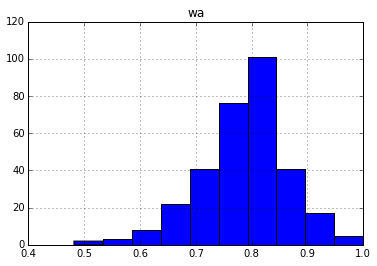

In [36]:
wa_df.hist()

In [43]:
wa_offpeak_df = pd.DataFrame(columns=['wa_offpeak'])
for route, stop in densest_stops.iteritems():
    stopslice = merged.loc[(route,'2015-12-03',stop)]
    wa_offpeak_df.loc[route] = stopslice[stopslice['P_hour']==False]['wait_ass'].mean()
wa_offpeak_df.mean()

wa_offpeak    0.819212
dtype: float64

In [52]:
# import numpy as np

In [53]:
# avg_wa_offpeak_all = pd.DataFrame(trip_groups)
# avg_wa_offpeak_all.columns=['N']
# avg_wa_offpeak_all['wa_offpeak'] = np.nan

In [54]:
# for i in trip_groups.index:
#    stopslice = merged.loc[(route,slice(None),stop)]
#    avg_wa_offpeak_all.loc[i,'wa_offpeak'] = stopslice[stopslice['P_hour']==False]['wait_ass'].mean()


KeyboardInterrupt


In [57]:
offpeak_data = merged[merged['P_hour']==False]

In [60]:
avg_wa_offpeak_all = pd.DataFrame(offpeak_data.groupby(level=(0,2))['wait_ass'].mean())
avg_wa_offpeak_all['N'] = offpeak_data.groupby(level=(0,2))['wait_ass'].size()

In [66]:
avg_wa_offpeak_all.rename(columns={'wait_ass':'wa_offpeak'},inplace=True)

In [67]:
avg_wa_offpeak_all.to_pickle('dec2015_offpeak.pickle')

## Best and worst routes at densest stop

In [75]:
wa_offpeak_df.sort('wa_offpeak',ascending=True)[20:40]

,wa_offpeak
B45,0.636364
M12,0.650000
B57,0.651163
BXM11,0.655172
S91,0.666667
QM4,0.666667
BXM8,0.666667
BX4A,0.675676
Q72,0.680000
M21,0.681818


### Stopped here

In [79]:
# trydata = data_pre('B1',300009)

In [80]:
# trydata.wait_ass.mean()

0.073170731707317069

In [308]:
###Only report for subway in MTA annual repo, permissible when the real arrival time within +-50% of the schedule headway
def headway_regularity(sche,inter):
    if inter >= 0.5*sche and inter <= 1.5*sche:
        return True
    else:
        return False    

In [309]:
merged['headway_reg']=map(lambda x,y:headway_regularity(x,y), merged['sched_headway'],merged['inter_headway'])

In [317]:
merged['headway_reg'].mean()

0.58112090512963088

In [316]:
hwr_df = pd.DataFrame(columns=['hwr'])
for route, stop in densest_stops.iteritems():
    hwr_df.loc[route] = merged.loc[(route,stop)]['headway_reg'].mean()
hwr_df.mean()

hwr    0.63227
dtype: float64

In [20]:
## on-time performance
## 1 min before or 5 min later compared with the schedule
## According to http://comptroller.nyc.gov/wp-content/uploads/documents/MH13_118A.pdf
## http://web.mta.info/developers/performance.html

In [311]:
def On_Time_Per(sche,inter):
    if inter > sche - 60 and inter <= sche + 300:
        return True
    else:
        return False

In [312]:
merged['OnTimeP'] = map(lambda x,y:On_Time_Per(x,y), merged['sched_headway'],merged['inter_headway'] )

In [313]:
merged['OnTimeP'].mean()

0.36036778568537842

In [318]:
otp_df = pd.DataFrame(columns=['otp'])
for route, stop in densest_stops.iteritems():
    otp_df.loc[route] = merged.loc[(route,stop)]['OnTimeP'].mean()
otp_df.mean()

otp    0.369241
dtype: float64

In [350]:
## Excess Wait Time
## According to http://greatergreaterwashington.org/post/2616/bus-on-time-performance-it-matters-what-you-measure/
def ewt(sche,inter):
    return max(0,inter-sche)

In [351]:
merged['ewt'] = map(lambda x,y: ewt(x,y), merged['sched_headway'],merged['inter_headway'])

In [26]:
## Trip Length for each trip, we need to compare the schedule trip length with actual trip length
## I saw the trip length distribution in Sponsor Report ppt, so I didn't add it here

In [345]:
## Headway Adherence
import numpy as np
def headway_adherence(sche,inter):
    if sche == 0:
        return None
    else:
        return 1.0* np.absolute(sche-inter)/sche

In [346]:
merged['headway_adh'] = map(lambda x,y: headway_adherence(x,y), merged['sched_headway'],merged['inter_headway'])

In [ ]:
## If the adherence function was applied on the beginning and ending time of the whole trip, we can get the running time adherence for a trip

In [352]:
merged[['wait_ass','headway_reg','OnTimeP','ewt','headway_adh']].mean()

wait_ass         0.770712
headway_reg      0.581121
OnTimeP          0.360368
ewt            195.497808
headway_adh      0.647194
dtype: float64

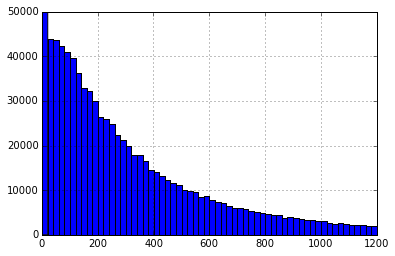

In [359]:
merged.ewt.hist(range=(1,1200),bins=60)

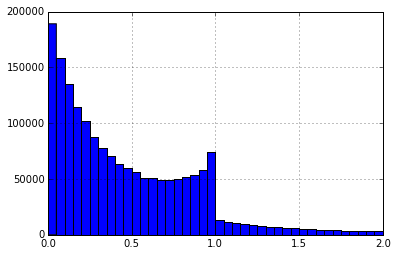

In [349]:
merged.headway_adh.hist(range=(0,2),bins=40)